<a href="https://colab.research.google.com/github/dariarozhnova/my_projects/blob/main/CodeForCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ALL CODE FOR CV COURSEWORK

# Google Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Local Path

In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the CW_folder_PG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_PG'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/CompVis/CW_Folder_PG/Code'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['CodeForCV.ipynb']


# Imports and paths to data

In [ ]:
import cv2
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
from sklearn import svm, metrics
from skimage.feature import hog
from skimage import exposure
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from skimage import io, color, img_as_float, img_as_ubyte

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
GOOGLE_DRIVE_PATH_MODELS = ('drive/My Drive/Colab Notebooks/CompVis/CW_Folder_PG')
CODE_PATH = os.path.join(GOOGLE_DRIVE_PATH_MODELS, 'Models')
sys.path.append(CODE_PATH)

## Path to training data images

In [ ]:
GOOGLE_DRIVE_PATH_DATA = 'Colab Notebooks/CompVis/CW_Folder_PG/CW_Dataset/train'
GOOGLE_DRIVE_DATA = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_DATA)
print(sorted(os.listdir(GOOGLE_DRIVE_DATA)))

## Training data labels preparation



In [ ]:
labels = open('drive/My Drive/Colab Notebooks/CompVis/CW_Folder_PG/CW_Dataset/labels/list_label_train.txt')
mylabels= labels.read().splitlines()
image_list =[]
label_list = []
for label in mylabels:
  image_code = label[:-1]
  image_code1 = image_code[:15]
  label_code=label[-1]
  image_list.append(image_code1)
  label_list.append(label_code)

#print(label_list)

# Name of emotions in order
label_names = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']
dic = {'1':'Surprise', '2':'Fear', '3':'Disgust', '4':'Happiness', '5':'Sadness', '6':'Sadness', '7':'Neutral'}
emotions_list_train=[dic.get(n, n) for n in label_list]

## Function for loading images

In [ ]:
#Adapted from https://stackoverflow.com/questions/30230592/loading-all-images-using-imread-from-a-given-folder
def load_images_from_folder(folder):
    images = []
    filenames = []
    #n_train_samples = 100
    for filename in sorted(os.listdir(folder)):#[:n_train_samples]:
      img = io.imread(os.path.join(folder,filename))
      if img is not None:
        images.append(img)
        filenames.append(filename)
    return images, filenames
    # You can specify the number of training samples in n_train_samples as 
    # the original training dataset is very large.

## Loading training data images

In [ ]:
images = load_images_from_folder(GOOGLE_DRIVE_DATA)[0]
filenames = load_images_from_folder(GOOGLE_DRIVE_DATA)[1]                                             
# a list of images as an array type uint8  with the actual pixel values (from 0 to 255).
print(filenames) 

#Turn into greyscale images (float64)
images_grey = []
for img in images:
  img = color.rgb2gray(img)  
  images_grey.append(img)


#It took around 5 mins to load images and filenames

We notice that our function shuffled the training dataset and also names of files in training dataset are different from names of the same files in labels dataset. Therefore, we want to match them for further use

In [ ]:
filenames_new=[]
for f in filenames:
  filenames_new.append(f[:11]+f[-4:])
print(filenames_new)

Extract labels for our training sample.

In [ ]:
training_labels=[]
for f in filenames_new:
  index = image_list.index(f)
  training_labels.append(label_list[index])

We know from the README file that all images are cropped to only include faces. They are roughly aligned to the eye level and centre of the mouth. And they are resized to 100x100. Therefore, we will not conduct any cleaning of the image files.

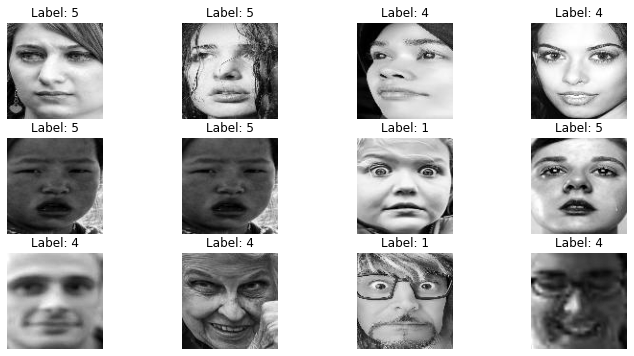

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 6), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(12):
    ax[i].imshow(images_grey[i], cmap='gray')
    ax[i].set_title(f'Label: {training_labels[i]}')
    ax[i].set_axis_off()
fig.tight_layout
plt.show()

# X_train and y_train 

In [ ]:
X_train = images_grey
y_train = np.asarray(training_labels).astype(int)

In [ ]:
import joblib

joblib.dump(X_train, 'X_train.joblib') 
joblib.dump(y_train, 'y_train.joblib')

['y_train.joblib']

## Path to testing data images

In [ ]:
GOOGLE_DRIVE_PATH_TEST_DATA = 'Colab Notebooks/CompVis/CW_Folder_PG/CW_Dataset/test'
GOOGLE_DRIVE_TEST_DATA = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_TEST_DATA)
print(sorted(os.listdir(GOOGLE_DRIVE_TEST_DATA)))

## Testing data label preparation

In [ ]:
labels_test = open('drive/My Drive/Colab Notebooks/CompVis/CW_Folder_PG/CW_Dataset/labels/list_label_test.txt')
mylabels_test= labels_test.read().splitlines()
image_list_test =[]
label_list_test = []
for label in mylabels_test:
  image_code = label[:-1]
  image_code1 = image_code[:13]
  label_code=label[-1]
  image_list_test.append(image_code1)
  label_list_test.append(label_code)

#print(label_list_test)

# Name of emotions in order
label_names = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']
dic = {'1':'Surprise', '2':'Fear', '3':'Disgust', '4':'Happiness', '5':'Sadness', '6':'Sadness', '7':'Neutral'}
emotions_list_test=[dic.get(n, n) for n in label_list_test]


## Loading testing data images

In [ ]:
images_test = load_images_from_folder(GOOGLE_DRIVE_TEST_DATA)[0]
filenames_test = load_images_from_folder(GOOGLE_DRIVE_TEST_DATA)[1]                                             
# a list of images as an array type uint8  with the actual pixel values (from 0 to 255).

#Turn into greyscale images (float64)
test_images_grey = []
for img in images_test:
  img = color.rgb2gray(img)  
  test_images_grey.append(img)

In [ ]:
filenames_new_t=[]
for f in filenames_test:
  filenames_new_t.append(f[:9]+f[-4:])


test_labels=[]
for f in filenames_new_t:
  index = image_list_test.index(f)
  test_labels.append(label_list_test[index])

# X_test and y_test

In [ ]:
X_test = test_images_grey
y_test = np.asarray(test_labels).astype(int)

In [ ]:
joblib.dump(X_test, 'X_test.joblib')
joblib.dump(y_test, 'y_test.joblib')

# Distribution of classes graph

We check how balanced the dataset is. We can see below that dataset is not balanced for the classes within each dataset (train and test) However, the distrubtion of classes is balanced across two datasets. So we will not rebalance the sets. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


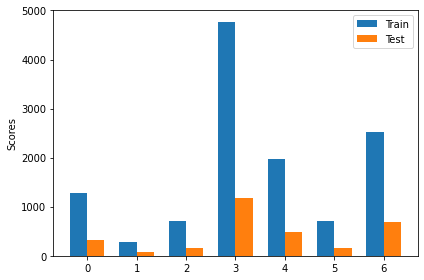

In [ ]:
# Adapted from https://matplotlib.org/3.5.0/gallery/lines_bars_and_markers/barchart.html
labels = ['1', '2', '3', '4', '5','6','7']
labels_traincount = [label_list.count('1'), label_list.count('2'), label_list.count('3'), label_list.count('4'),label_list.count('5'),label_list.count('6'),label_list.count('7')]
labels_testcount = [label_list_test.count('1'), label_list_test.count('2'), label_list_test.count('3'), label_list_test.count('4'),label_list_test.count('5'),label_list_test.count('6'),label_list_test.count('7')]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, labels_traincount, width, label='Train')
rects2 = ax.bar(x + width/2, labels_testcount, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

# Creating sample dataset 

In [ ]:
# Extecting subset of images proportional to each class for training:
#'Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral'
surprise=[]
fear=[]
disgust=[]
happiness=[]
sadness=[]
anger=[]
neutral=[]
X = [list(e) for e in zip(y_train, filenames_new, images_grey)]

for x in X:
  if x[0]==1:
    surprise.append(x)
  if x[0]==2:
    fear.append(x)
  if x[0]==3:
    disgust.append(x)
  if x[0]==4:
    happiness.append(x)
  if x[0]==5:
    sadness.append(x)
  if x[0]==6:
    anger.append(x)
  else:
    neutral.append(x)

subsets=[surprise,fear,disgust,happiness,sadness,anger,neutral]
new_slice1=round(len(surprise)/4)
sample1 = surprise[:new_slice1]

new_slice2=round(len(fear)/4)
sample2 = fear[:new_slice2]

new_slice3=round(len(disgust)/4)
sample3 = disgust[:new_slice3]

new_slice4=round(len(happiness)/4)
sample4 = happiness[:new_slice4]

new_slice5=round(len(sadness)/4)
sample5 = sadness[:new_slice5]

new_slice6=round(len(anger)/4)
sample6 = anger[:new_slice6]

new_slice7=round(len(neutral)/4)
sample7 = neutral[:new_slice7]

sample = sample1 + sample2 + sample3 + sample4 + sample5 + sample6 + sample7

In [ ]:
y = []
X = []
for s in sample:
  y.append(s[0])
  X.append(s[2])



In [ ]:
joblib.dump(X,'x_sample.joblib')
joblib.dump(y, 'y_sample.joblib')

['y_sample.joblib']

# HOG + MLP on sample data

## Selection of best parameters for HOG features extraction

Selecting the best HOG parameters with MLP classifier (baseline model) 
Based on validation accuracy score on 3-fold CV

In [ ]:
y = joblib.load('y_sample.joblib')
X = joblib.load('x_sample.joblib')

hog_features1 = []
hog_features2 = []
hog_features3 = []
hog_features4 = []

for image in X:
  hog_feature1= hog(image, orientations=9, pixels_per_cell=(8,8),cells_per_block=(1,1),block_norm='L2')
  hog_features1.append(hog_feature1)
  hog_feature2= hog(image, orientations=9, pixels_per_cell=(8,8),cells_per_block=(2,2),block_norm='L2')
  hog_features2.append(hog_feature2)
  hog_feature3= hog(image, orientations=8, pixels_per_cell=(8,8),cells_per_block=(1,1),block_norm='L2')
  hog_features3.append(hog_feature3)
  hog_feature4= hog(image, orientations=8, pixels_per_cell=(8,8),cells_per_block=(2,2),block_norm='L2')
  hog_features4.append(hog_feature4)

clf = MLPClassifier()
clf.fit(hog_features1, y)
scores = cross_val_score(clf,hog_features1, y,cv = 3, verbose = 3)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

clf.fit(hog_features2, y)
scores = cross_val_score(clf,hog_features2, y ,cv = 3, verbose = 3)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

clf.fit(hog_features3, y)
scores = cross_val_score(clf,hog_features3, y,cv = 3, verbose = 3)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

clf.fit(hog_features4, y)
scores = cross_val_score(clf,hog_features4, y,cv = 3, verbose = 3)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.973) total time=  20.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.8s remaining:    0.0s


[CV] END ................................ score: (test=0.925) total time=  20.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   41.0s remaining:    0.0s


[CV] END ................................ score: (test=0.925) total time=  21.2s
0.94 accuracy with a standard deviation of 0.02


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.975) total time=  53.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.3s remaining:    0.0s


[CV] END ................................ score: (test=0.926) total time=  57.5s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s


[CV] END ................................ score: (test=0.936) total time=  43.8s
0.95 accuracy with a standard deviation of 0.02


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.977) total time=  23.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.7s remaining:    0.0s


[CV] END ................................ score: (test=0.929) total time=  18.5s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   42.1s remaining:    0.0s


[CV] END ................................ score: (test=0.925) total time=  19.5s
0.94 accuracy with a standard deviation of 0.02


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.978) total time=  44.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   44.0s remaining:    0.0s


[CV] END ................................ score: (test=0.932) total time=  39.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


[CV] END ................................ score: (test=0.929) total time=  42.5s
0.95 accuracy with a standard deviation of 0.02


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.1min finished


In [ ]:
dump(hog_features1, 'HOG_features1.joblib') 
dump(hog_features2, 'HOG_features2.joblib') 
dump(hog_features3, 'HOG_features3.joblib') 
dump(hog_features4, 'HOG_features4.joblib') 

['HOG_features4.joblib']

## Grid Search on MLP with best HOG features

In [ ]:
# Create a classifier: Multi-Layer Perceptron
best_features = joblib.load('HOG_features4.joblib')
start=time.time()
MLP = MLPClassifier(activation='relu',solver='sgd',  learning_rate='constant', max_iter=300,early_stopping = True)
param_grid = {'hidden_layer_sizes':[(100,),(200,),(100,100),(200,200)],
              'learning_rate_init':[0.1,0.01], 
              'momentum': [0.7,0.9],
}
mlp_search=GridSearchCV(MLP,param_grid,cv=3,verbose=3).fit(best_features,y)
print(mlp_search.best_score_)
print(mlp_search.best_params_)
stop = time.time()
print(f"Training time: {stop - start}s")
#0.932633903920486
#{'hidden_layer_sizes': (200,), 'learning_rate_init': 0.1, 'momentum': 0.9}
#Training time: 1070.3298032283783s

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END hidden_layer_sizes=(100,), learning_rate_init=0.1, momentum=0.7;, score=0.923 total time=   9.9s
[CV 2/3] END hidden_layer_sizes=(100,), learning_rate_init=0.1, momentum=0.7;, score=0.872 total time=   8.9s
[CV 3/3] END hidden_layer_sizes=(100,), learning_rate_init=0.1, momentum=0.7;, score=0.903 total time=  10.3s
[CV 1/3] END hidden_layer_sizes=(100,), learning_rate_init=0.1, momentum=0.9;, score=0.957 total time=  11.7s
[CV 2/3] END hidden_layer_sizes=(100,), learning_rate_init=0.1, momentum=0.9;, score=0.920 total time=  11.6s
[CV 3/3] END hidden_layer_sizes=(100,), learning_rate_init=0.1, momentum=0.9;, score=0.918 total time=  10.6s
[CV 1/3] END hidden_layer_sizes=(100,), learning_rate_init=0.01, momentum=0.7;, score=0.882 total time=  20.7s
[CV 2/3] END hidden_layer_sizes=(100,), learning_rate_init=0.01, momentum=0.7;, score=0.872 total time=  30.9s
[CV 3/3] END hidden_layer_sizes=(100,), learning_rate_ini

As the result, of selection on HOG parameters and Grid Search for MLP on sample set. The best trained model, based on validation accuracy, is extracted and will be applied to the whole training set. 

## Table of Grid Search Results

In [ ]:
import pandas as pd
mlp_trained = pd.concat([pd.DataFrame(mlp_search.cv_results_["params"]),pd.DataFrame(mlp_search.cv_results_["mean_test_score"],columns= ['Validation Score'])],axis=1)
mlp_trained

,hidden_layer_sizes,learning_rate_init,momentum,Validation Score
0,"(100,)",0.10,0.7,0.899503
1,"(100,)",0.10,0.9,0.931714
2,"(100,)",0.01,0.7,0.878704
3,"(100,)",0.01,0.9,0.907970
4,"(200,)",0.10,0.7,0.918461
5,"(200,)",0.10,0.9,0.932634
6,"(200,)",0.01,0.7,0.872078
7,"(200,)",0.01,0.9,0.911651
8,"(100, 100)",0.10,0.7,0.877784
9,"(100, 100)",0.10,0.9,0.864348


In [ ]:
dump(mlp_search, 'MLP_GridSearch.joblib') 

['MLP_GridSearch.joblib']

# Best HOG + MLP on full training set

In [ ]:
def best_trained_MLP_HOG(X_train,y_train):
  start =time.time()
  hog_features =[]
  hog_images =[]

  for image in X_train:
    hog_feature, hog_image = hog(image, orientations=8, pixels_per_cell=(8,8),cells_per_block=(2,2),
                                block_norm='L2',visualize=True)
    hog_features.append(hog_feature)
    hog_images.append(hog_image)
  MLP = MLPClassifier(hidden_layer_sizes= (200,),activation='relu',solver='sgd',
                    learning_rate='constant',learning_rate_init=0.1,momentum=0.9, max_iter=300,early_stopping = True)

  MLP.fit(hog_features,y_train)
  accuracy = MLP.score(hog_features,y_train)
  scores = cross_val_score(MLP,hog_features, y_train ,cv = 3)
  stop = time.time()
  training_time = stop - start
  return MLP, hog_images, accuracy, training_time, scores



In [ ]:
import os
filename = os.path.join(CODE_PATH, 'MLP_HOG.py')
joblib.dump(best_trained_MLP_HOG(X_train,y_train),filename)


['drive/My Drive/Colab Notebooks/CompVis/CW_Folder_PG/Models/MLP_HOG.py']

In [ ]:
filename = os.path.join(CODE_PATH, 'MLP_HOG.py')
MLP_HOG= joblib.load(filename)
MLP,hog_images, accuracy, training_time, scores= MLP_HOG[0],MLP_HOG[1],MLP_HOG[2],MLP_HOG[3], MLP_HOG[4]


# Quantitative and qualitative results of HOG + MLP

MLP best trained model and HOG best parameter combination resuts in terms of time, training accuracy and visuals HOGs on a full set


0.98 training accuracy
512.06 training time
0.70 validation accuracy with a standard deviation of 0.02


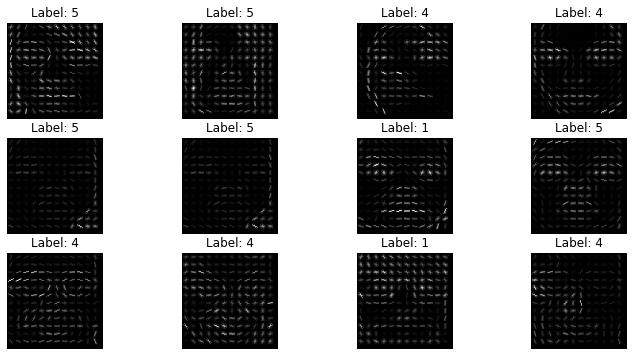

In [ ]:
print("%0.2f training accuracy" % accuracy)
print("%0.2f training time" % training_time)
print("%0.2f validation accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

#Lab 6:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 6), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(12):
    ax[i].imshow(hog_images[i], cmap='gray')
    ax[i].set_title(f'Label: {y_train[i]}')
    ax[i].set_axis_off()
fig.tight_layout
plt.show()

# Testing results HOG + MLP

In [ ]:
hog_features_test= []
for image in X_test:
  hog_feature_t = hog(image, orientations=8, pixels_per_cell=(8,8),cells_per_block=(2, 2),block_norm= 'L2')
  hog_features_test.append(hog_feature_t)

## Display of images on test set

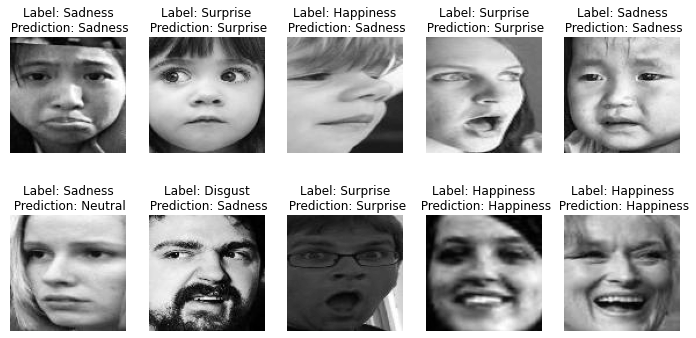

In [ ]:
y_pred = MLP.predict(hog_features_test)

# Name of emotions in order

dic = {1:'Surprise', 2:'Fear', 3:'Disgust', 4:'Happiness', 5:'Sadness', 6:'Sadness', 7:'Neutral'}
emotions_test=[dic.get(n, n) for n in y_test]
emotions_pred=[dic.get(n, n) for n in y_pred]
# Lab 6:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_test[i], cmap='gray')
    ax[i].set_title(f'Label: {emotions_test[i]}\n Prediction: {emotions_pred[i]}')
    ax[i].set_axis_off()

fig.tight_layout
plt.show()

## Confusion matrix and evaluation metrics

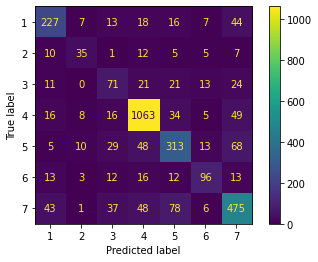

Classification report for classifier MLPClassifier(early_stopping=True, hidden_layer_sizes=(200,),
              learning_rate_init=0.1, max_iter=300, solver='sgd'):
                    precision    recall  f1-score   support

           1       0.70      0.68      0.69       332
           2       0.55      0.47      0.50        75
           3       0.40      0.44      0.42       161
           4       0.87      0.89      0.88      1191
           5       0.65      0.64      0.65       486
           6       0.66      0.58      0.62       165
           7       0.70      0.69      0.69       688

    accuracy                           0.74      3098
   macro avg       0.65      0.63      0.64      3098
weighted avg       0.73      0.74      0.74      3098




In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

print(f"""Classification report for classifier {MLP}:
      {metrics.classification_report(y_test, y_pred)}\n""")

# HOG + SVM on sample data

## Selection of best parameters for HOG features extraction  

In [ ]:
hog_features1=load('HOG_features1.joblib') 
hog_features2=load('HOG_features2.joblib') 
hog_features3=load('HOG_features3.joblib') 
hog_features4=load('HOG_features4.joblib') 
clf = svm.SVC()
clf.fit(hog_features1, y)
scores = cross_val_score(clf,hog_features1, y,cv = 3, verbose = 3)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

clf.fit(hog_features2, y)
scores = cross_val_score(clf,hog_features2, y,cv = 3, verbose = 3)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

clf.fit(hog_features3, y)
scores = cross_val_score(clf,hog_features3, y,cv = 3, verbose = 3)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

clf.fit(hog_features4, y)
scores = cross_val_score(clf,hog_features4, y,cv = 3, verbose = 3)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.932) total time=  12.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.2s remaining:    0.0s


[CV] END ................................ score: (test=0.896) total time=  12.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   24.4s remaining:    0.0s


[CV] END ................................ score: (test=0.922) total time=  11.2s
0.92 accuracy with a standard deviation of 0.02


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   35.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.939) total time=  57.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.2s remaining:    0.0s


[CV] END ................................ score: (test=0.902) total time=  56.9s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


[CV] END ................................ score: (test=0.930) total time=  52.7s
0.92 accuracy with a standard deviation of 0.02


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.931) total time=  10.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.7s remaining:    0.0s


[CV] END ................................ score: (test=0.900) total time=  10.8s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.5s remaining:    0.0s


[CV] END ................................ score: (test=0.919) total time=   9.9s
0.92 accuracy with a standard deviation of 0.01


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.939) total time=  50.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   50.1s remaining:    0.0s


[CV] END ................................ score: (test=0.901) total time=  49.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


[CV] END ................................ score: (test=0.929) total time=  46.8s
0.92 accuracy with a standard deviation of 0.02


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.4min finished


## Grid Search for SVM hyperparameters with best HOG parameters

In [ ]:
best_features = joblib.load('HOG_features4.joblib')
start=time.time()
SVM = svm.SVC()
param_grid = [
  {'C': [1, 10], 'kernel': ['linear']},
  {'C': [1, 10], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svm_search=GridSearchCV(SVM,param_grid,cv=3,verbose=3).fit(best_features,y)
print(svm_search.best_score_)
print(svm_search.best_params_)
stop = time.time()
print(f"Training time: {stop - start}s")
#0.9423891036259894
#{'C': 1, 'kernel': 'linear'}
#Training time: 765.8087964057922s

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ................C=1, kernel=linear;, score=0.975 total time=  28.9s
[CV 2/3] END ................C=1, kernel=linear;, score=0.929 total time=  27.5s
[CV 3/3] END ................C=1, kernel=linear;, score=0.923 total time=  28.1s
[CV 1/3] END ...............C=10, kernel=linear;, score=0.975 total time=  29.9s
[CV 2/3] END ...............C=10, kernel=linear;, score=0.929 total time=  32.7s
[CV 3/3] END ...............C=10, kernel=linear;, score=0.923 total time=  28.1s
[CV 1/3] END ......C=1, gamma=0.001, kernel=rbf;, score=0.769 total time=  57.2s
[CV 2/3] END ......C=1, gamma=0.001, kernel=rbf;, score=0.763 total time=  53.6s
[CV 3/3] END ......C=1, gamma=0.001, kernel=rbf;, score=0.750 total time=  52.1s
[CV 1/3] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.591 total time=  55.2s
[CV 2/3] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.591 total time=  53.1s
[CV 3/3] END .....C=1, gamma=0.0001, kernel=rbf;,

## Table of Grid Search results

In [ ]:
import pandas as pd
svm_trained = pd.concat([pd.DataFrame(svm_search.cv_results_["params"]),pd.DataFrame(svm_search.cv_results_["mean_test_score"],columns= ['Validation Score'])],axis=1)
#svm_trained.to_excel('svm.xlsx')
svm_trained

,C,kernel,gamma,Validation Score
0,1,linear,NaN,0.942389
1,10,linear,NaN,0.942389
2,1,rbf,0.0010,0.760906
3,1,rbf,0.0001,0.591386
4,10,rbf,0.0010,0.894165
5,10,rbf,0.0001,0.766059


In [ ]:
dump(svm_search, 'SVM_GridSearch.joblib') 

['SVM_GridSearch.joblib']

# Best HOG + SVM on full training set

In [ ]:
from sklearn import svm
def best_trained_SVM_HOG(X_train,y_train):
  start =time.time()
  hog_features =[]
  hog_images =[]

  for image in X_train:
    hog_feature, hog_image = hog(image, orientations=8, pixels_per_cell=(8,8),cells_per_block=(2,2),
                                block_norm='L2',visualize=True)
    hog_features.append(hog_feature)
    hog_images.append(hog_image)

  SVM = svm.SVC(C=1,kernel='linear')

  SVM.fit(hog_features,y_train)
  accuracy = SVM.score(hog_features,y_train)
  scores = cross_val_score(SVM,hog_features, y_train ,cv = 3)
  stop = time.time()
  training_time = stop - start
  return SVM, hog_images, accuracy, training_time,scores


In [ ]:
import os
filename = os.path.join(CODE_PATH, 'SVM_HOG.py')
joblib.dump(best_trained_SVM_HOG(X_train,y_train),filename)

['drive/My Drive/Colab Notebooks/CompVis/CW_Folder_PG/Models/SVM_HOG.py']

In [ ]:
filename = os.path.join(CODE_PATH, 'SVM_HOG.py')
SVM_HOG= joblib.load(filename)
SVM,hog_images, accuracy, training_time ,scores= SVM_HOG[0],SVM_HOG[1],SVM_HOG[2],SVM_HOG[3], SVM_HOG[4]


# Quantitative and qualitative results of HOG + SVM

0.99 training accuracy
1459.52 training time
0.65 validation accuracy with a standard deviation of 0.02


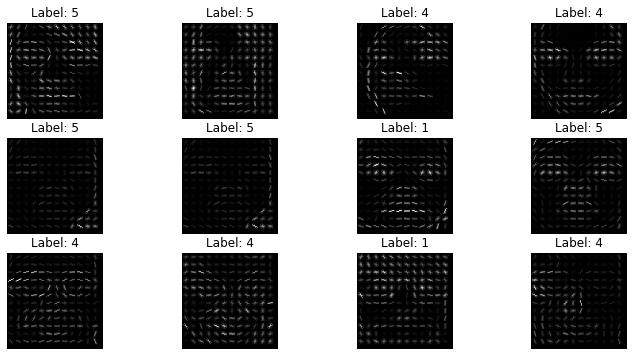

In [ ]:
print("%0.2f training accuracy" % accuracy)
print("%0.2f training time" % training_time)
print("%0.2f validation accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
#Lab 6:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 6), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(12):
    ax[i].imshow(hog_images[i], cmap='gray')
    ax[i].set_title(f'Label: {y_train[i]}')
    ax[i].set_axis_off()
fig.tight_layout
plt.show()

# Testing results HOG + SVM 

## Display of images on test set

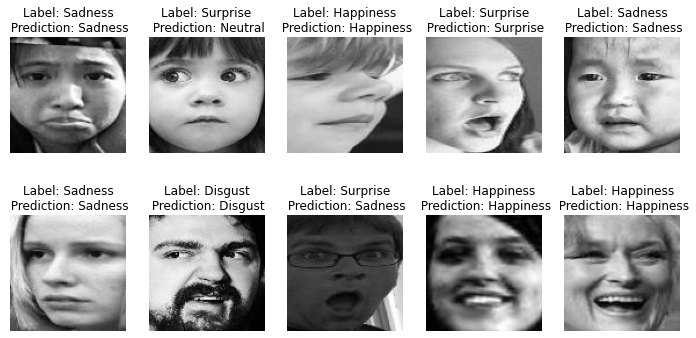

In [ ]:
y_pred_svm = SVM.predict(hog_features_test)

dic = {1:'Surprise', 2:'Fear', 3:'Disgust', 4:'Happiness', 5:'Sadness', 6:'Sadness', 7:'Neutral'}
emotions_test=[dic.get(n, n) for n in y_test]
emotions_pred=[dic.get(n, n) for n in y_pred_svm]

# Lab 6:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_test[i], cmap='gray')
    ax[i].set_title(f'Label: {emotions_test[i]}\n Prediction: {emotions_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout
plt.show()

## Confusion matrix and evaluation metrics

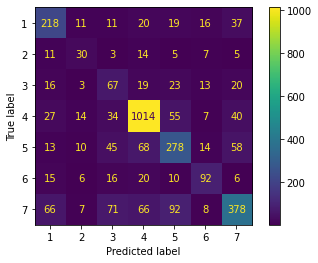

Classification report for classifier SVC(C=1, kernel='linear'):
                    precision    recall  f1-score   support

           1       0.60      0.66      0.62       332
           2       0.37      0.40      0.38        75
           3       0.27      0.42      0.33       161
           4       0.83      0.85      0.84      1191
           5       0.58      0.57      0.57       486
           6       0.59      0.56      0.57       165
           7       0.69      0.55      0.61       688

    accuracy                           0.67      3098
   macro avg       0.56      0.57      0.56      3098
weighted avg       0.68      0.67      0.67      3098




In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm)
plt.show()
print(f"""Classification report for classifier {SVM}:
      {metrics.classification_report(y_test, y_pred_svm)}\n""")

# CNN (Convolutional Neural Networks) 

Before this part is implemented, need to change Runtime to CPU accelerator

## Setup of Device

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


## Training validation split

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3)

## Transforming into tensors 

In [ ]:
train_x=[]
for i in range(len(x_train)):
  train_x.append([torch.from_numpy(np.asarray(x_train[i])),torch.from_numpy(np.asarray(y_train[i]))])
val_x=[]
for i in range(len(x_val)):
  val_x.append([torch.from_numpy(np.asarray(x_val[i])),torch.from_numpy(np.asarray(y_val[i]))])

test_x=[]
for i in range(len(X_test)):
  test_x.append([torch.from_numpy(np.asarray(X_test[i])),torch.from_numpy(np.asarray(y_test[i]))])



## Batching (batch size = 4)  

In [ ]:
# Idea is taken from Lab 8: 
trainloader = torch.utils.data.DataLoader(train_x, batch_size=4,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_x, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_x, batch_size=4,
                                          shuffle=True, num_workers=2)

## 2D Convolutional NN setup

In [ ]:
# Adapted from https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/
class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(25 * 10 * 10, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

net = Net()
net.to(device)
import joblib
filename = os.path.join(CODE_PATH, 'CNN.py')
joblib.dump(net,filename)

['drive/My Drive/Colab Notebooks/CompVis/CW_Folder_PG/Models/CNN.py']

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

## PyTorch Training

In [ ]:
#Adapted from https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/
import time
import numpy as np
start =time.time()
epochs = 5
min_valid_loss = np.inf

for epoch in range(epochs):
    train_loss = 0.0
    net.train()     # Optional when not using Model Specific layer
    for data, labels in trainloader:
        data, labels = data.to(device),labels.to(device)
        data=data.float()
        data= data.unsqueeze(1)
        
        optimizer.zero_grad()
        target = net(data)
        loss = criterion(target,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    valid_loss = 0.0
    net.eval()    
    for data, labels in valloader:
        data, labels = data.to(device),labels.to(device)
        data=data.float()
        data= data.unsqueeze(1)
        target = net(data)
        loss = criterion(target,labels)
        valid_loss = loss.item() * data.size(0)

    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(trainloader)} \t\t Validation Loss: {valid_loss / len(valloader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        PATH = os.path.join(CODE_PATH,'CNN.pth')
        torch.save(net.state_dict(), PATH)
stop = time.time()
print(f"Training time: {stop - start}s")

Epoch 1 		 Training Loss: 1.7085960492695849 		 Validation Loss: 0.002759875073092687
Validation Loss Decreased(inf--->2.591523) 	 Saving The Model
Epoch 2 		 Training Loss: 1.6609896059177782 		 Validation Loss: 0.0045113238536765654
Epoch 3 		 Training Loss: 1.6581903468256127 		 Validation Loss: 0.0020522855468197497
Validation Loss Decreased(2.591523--->1.927096) 	 Saving The Model
Epoch 4 		 Training Loss: 1.6558474685503468 		 Validation Loss: 0.004121625512298811
Epoch 5 		 Training Loss: 1.6564672164448864 		 Validation Loss: 0.001893323704330558
Validation Loss Decreased(1.927096--->1.777831) 	 Saving The Model
Training time: 59.85708475112915s


In [ ]:
import joblib
model = os.path.join(CODE_PATH, 'CNN.py')
net= joblib.load(model)
PATH = os.path.join(CODE_PATH, 'CNN.pth')
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Validation accuracy

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in valloader:
        images, labels = data[0].to(device),data[1].to(device)
        images = images.float()
        images = images.unsqueeze(1)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy validation: {100 * correct / total}%")

Accuracy validation: 40.06393180607352%


## Training Accuracy

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device),data[1].to(device)
        images = images.float()
        images = images.unsqueeze(1)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy training: {100 * correct / total}%")

Accuracy training: 38.64596415115881%


## Testing Accuracy

In [ ]:
correct = 0
total = 0
import matplotlib.pyplot as plt

pred=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device),data[1].to(device)
        images = images.float()
        images = images.unsqueeze(1)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted=predicted.cpu()
        images= images.cpu()
        labels= labels.cpu()
        pred.append([predicted,images,labels])
print(f"Accuracy testing: {100 * correct / total}%")

Accuracy testing: 38.44415752098128%


## Displaying testing images

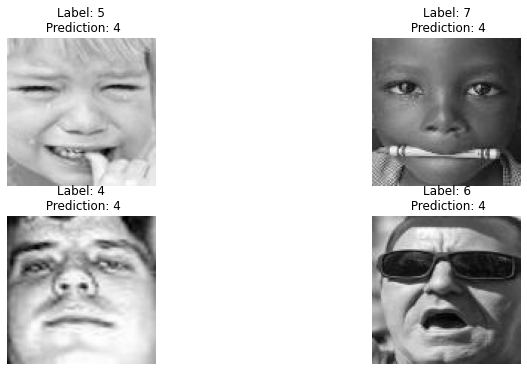

In [ ]:
predicted,images,labels= pred[0]

images_list = images.numpy().reshape(4,100,100).tolist()
labels_list = labels.numpy().tolist()
predicted_list = predicted.numpy().tolist()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), sharex=True, sharey=True)
ax = axes.ravel()
for i in range(4):
  ax[i].imshow(images_list[i], cmap='gray')
  ax[i].set_title(f'Label: {labels_list[i]}\n Prediction: {predicted_list[i]}')
  ax[i].set_axis_off()
fig.tight_layout
plt.show() 
# show images and print labels
#plt.imshow(np.transpose(npimg, (1, 2, 0)))     # Reshape: C, H, W -> H, W, C
  #  plt.show()

In [ ]:
all_labels =[]
all_pred = []
for i in pred:
  labels_list = i[2].numpy().tolist()
  for list_l in labels_list:
    all_labels.append(list_l)
for i in pred:
  predicted_list = i[0].numpy().tolist()
  for list_p in predicted_list:
    all_pred.append(list_p)

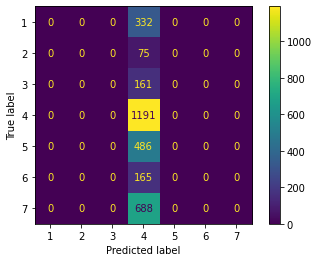

Classification report for classifier CNN:
                    precision    recall  f1-score   support

           1       0.00      0.00      0.00       332
           2       0.00      0.00      0.00        75
           3       0.00      0.00      0.00       161
           4       0.38      1.00      0.56      1191
           5       0.00      0.00      0.00       486
           6       0.00      0.00      0.00       165
           7       0.00      0.00      0.00       688

    accuracy                           0.38      3098
   macro avg       0.05      0.14      0.08      3098
weighted avg       0.15      0.38      0.21      3098




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(all_labels,all_pred)
plt.show()
print(f"""Classification report for classifier CNN:
      {metrics.classification_report(all_labels, all_pred)}\n""")

# Emotion Recognition Function (LOCAL TRY) 

THIS IS THE PRELIMINARY FUNCTION OF EMOTIONS RECOGNITIONS FOR LOCAL TESTING.  FOR FINAL VERSION, PLEASE REFER TO test_fucntion.ipynb FILE

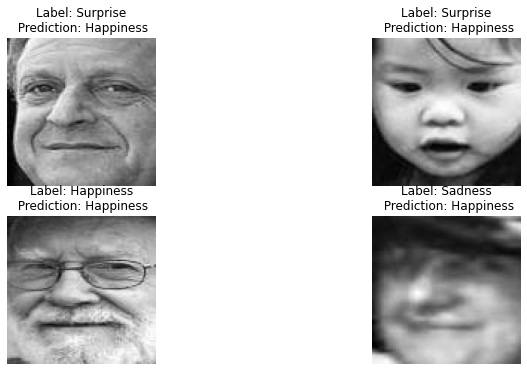

In [ ]:
GOOGLE_DRIVE_PATH_MODELS = ('drive/My Drive/Colab Notebooks/CompVis/CW_Folder_PG')
CODE_PATH = os.path.join(GOOGLE_DRIVE_PATH_MODELS, 'Models')
GOOGLE_DRIVE_PATH_TEST_DATA = 'Colab Notebooks/CompVis/CW_Folder_PG/CW_Dataset/test'
GOOGLE_DRIVE_TEST_DATA = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_TEST_DATA)

def EmotionRecognition(path_to_testset,model_type):
  images_test = []
  filenames = []
  n_train_samples = 4
  for filename in os.listdir(path_to_testset)[3:n_train_samples+3]:
    img = io.imread(os.path.join(path_to_testset,filename))
    if img is not None:
      images_test.append(img)
      filenames.append(filename)
  labels_test = open('drive/My Drive/Colab Notebooks/CompVis/CW_Folder_PG/CW_Dataset/labels/list_label_test.txt')
  mylabels_test= labels_test.read().splitlines()
  image_list_test =[]
  label_list_test = []
  for label in mylabels_test:
    image_code = label[:-1]
    image_code1 = image_code[:13]
    label_code=label[-1]
    image_list_test.append(image_code1)
    label_list_test.append(label_code)
  filenames_new_t=[]
  for f in filenames:
    filenames_new_t.append(f[:9]+f[-4:])

  test_labels=[]
  for f in filenames_new_t:
    index = image_list_test.index(f)
    test_labels.append(label_list_test[index])
  test_images_grey = []
  for img in images_test:
    img = color.rgb2gray(img)  
    test_images_grey.append(img)
  X_test = test_images_grey
  

  hog_features_test= []
  for image in X_test:
    hog_feature_t = hog(image, orientations=8, pixels_per_cell=(8,8),cells_per_block=(2, 2),block_norm= 'L2')
    hog_features_test.append(hog_feature_t)
  global y_pred
  global y_test
  global images
  if model_type == 'SVM_HOG':
    model_filename = os.path.join(CODE_PATH, 'SVM_HOG.py')
    model_HOG= joblib.load(model_filename)
    model= model_HOG[0]
    images = X_test
    y_pred = model.predict(hog_features_test)
    y_test = np.asarray(test_labels).astype(int)
  if model_type == 'MLP_HOG':
    model_filename = os.path.join(CODE_PATH, 'MLP_HOG.py')
    model_HOG= joblib.load(model_filename)
    model= model_HOG[0]
    images = X_test
    y_pred = model.predict(hog_features_test)
    y_test = np.asarray(test_labels).astype(int)
  if model_type == "CNN":
    PATH = os.path.join(CODE_PATH, 'CNN.pth')
    net = Net()
    net.load_state_dict(torch.load(PATH))
    net.to(device)
    test_x=[]
    for i in range(len(X_test)):
      test_x.append([torch.from_numpy(np.asarray(X_test[i])),torch.from_numpy(np.asarray(y_test[i]))])
    testloader = torch.utils.data.DataLoader(test_x, batch_size=4,shuffle=True, num_workers=2)
    pred = []
    with torch.no_grad():
      for data in testloader:
        images, labels = data[0].to(device),data[1].to(device)
        images = images.float()
        images = images.unsqueeze(1)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        predicted=predicted.cpu()
        images= images.cpu()
        labels= labels.cpu()
        pred.append([predicted,images,labels])
    predicted,images,labels= pred[0]

    images = images.numpy().reshape(4,100,100).tolist()
    y_test = labels.numpy().tolist()
    y_pred = predicted.numpy().tolist()

  dic = {1:'Surprise', 2:'Fear', 3:'Disgust', 4:'Happiness', 5:'Sadness', 6:'Sadness', 7:'Neutral'}
  emotions_test=[dic.get(n, n) for n in y_test]
  emotions_pred=[dic.get(n, n) for n in y_pred] 
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), sharex=True, sharey=True)
  ax = axes.ravel()

  for i in range(4):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_title(f'Label: {emotions_test[i]}\n Prediction: {emotions_pred[i]}')
    ax[i].set_axis_off()
    
  fig.tight_layout
  plt.show() 

EmotionRecognition(GOOGLE_DRIVE_TEST_DATA,'CNN')